In [3]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.lines as lines
import time
import math

In [315]:
# Configuration variables
a = 2
q = 9
omega = 1.5

nx = 50
ny = 50
L = ny
X, Y = np.meshgrid(np.arange(0,nx+2), np.arange(0,ny+2))

ub = 0.01
vb = 0
velocity_boundary = np.array([ub,vb])

ub_init = np.empty((ny+2))
ub_init.fill(ub)
u_init = np.stack((np.zeros((ny+2)), ub_init), axis = 0)

# Density weight contribution along the q different directions
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# Velocity components
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1],    # Velocity x-component
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])   # Velocity y-component

# debug flags
collision = True

In [316]:
def f_eq(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm,anm->nm',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def f_eq_i(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,an->n', c_ai.T[i], u)
        uu = np.einsum('an,an->n',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq


def rho_in():
    f = np.einsum("i,j->ij", w_i, np.ones((nx+2)))
    rho = np.einsum("ij->j", f)
    return rho

def rho_out():
    f = np.einsum("i,j->ij", w_i, np.ones((nx+2)))
    rho = np.einsum("ij->j", f)
    return rho

def plot_density(arr, plt_index=None):
    %matplotlib inline
    
    fig, ax = plt.subplots()
    if plt_index is not None:
        ax.set_title(f"Step {plt_index}")
    
    line_top = lines.Line2D([0.5, 0.5+nx],
                        [0.5, 0.5],
                        color ='black')
    line_bottom = lines.Line2D([0.5, 0.5+nx],
                        [0.5+ny, 0.5+ny],
                        color ='black')
    ax.add_line(line_top)
    ax.add_line(line_bottom)

#     ax.add_patch(Rectangle((0.5,0.5), nx, ny, fill = False))
    ax.imshow(arr.T)
    plt.gca().invert_yaxis()

In [317]:
def stream_couette(f_inm):

    ##### Reference rows:
    f_bottom = np.array(f_inm[:,:,1])
    f_1 = np.array(f_inm[:,:,nx])

    ##### Streaming
    for i in range(9):
        f_inm[i,:,:] = np.roll(f_inm[i,:,:], shift = c_ai.T[i], axis=[0,1])
    
    ##### Wall
    
    f_1_i = np.array(f_inm[:,:,ny])
    
    for i in range(0, nx+2):
        # top boundary
        
        rho_n = (f_1_i[0,i] + f_1_i[1,i] + f_1_i[3,i] + 2*(f_1[2,i] + f_1[6,i] + f_1[5,i]))/(1+vb)
        f_inm[4,i,ny] = f_1[2,i] - (2/3)*rho_n*vb
        f_inm[7,i,ny] = f_1[5,i] + 0.5*(f_1_i[1,i]-f_1_i[3,i]) - 0.5*rho_n*ub - (1/6)*rho_n*vb
        f_inm[8,i,ny] = f_1[6,i] + 0.5*(f_1_i[3,i]-f_1_i[1,i]) + 0.5*rho_n*ub - (1/6)*rho_n*vb
        
        # bottom boundary
        
        f_inm[2,i,1] = f_bottom[4,i]
        f_inm[5,i,1] = f_bottom[7,i]
        f_inm[6,i,1] = f_bottom[8,i]
    
    ##### Collision
    
    rho = np.einsum("ijk->jk", f_inm)
    u = np.einsum('ai,ijk->ajk',c_ai,f_inm)/rho
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm->nm',u**2)
        term = rho*w_i[i]*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    f_inm = f_inm + (omega * (feq - f_inm))
    
    rho = np.einsum("ijk->jk", f_inm)
    u = np.einsum('ai,ijk->ajk',c_ai,f_inm)/rho
#     plot_density(rho)

    return f_inm, rho, u

In [318]:
def stream_loop(f, iter_length, value_log_period, plot):
    u_periodic = np.empty((iter_length//value_log_period, ny+2))

    for i in range(iter_length):
        f, rho, u = stream_couette(f)
        if i%value_log_period==0:
            print(i)

            u_periodic[i//value_log_period] = u[0,nx//2,:]
            
            if plot:
                plot_density(rho)
                plt.streamplot(X, Y, u[0].T, u[1].T)
                plt.show()
            
    return u_periodic

# u_periodic = stream_loop(f, 10, 1, plot=True)


### Simulate for 10000 steps

0


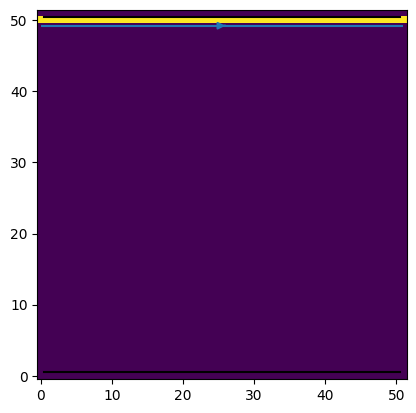

1000


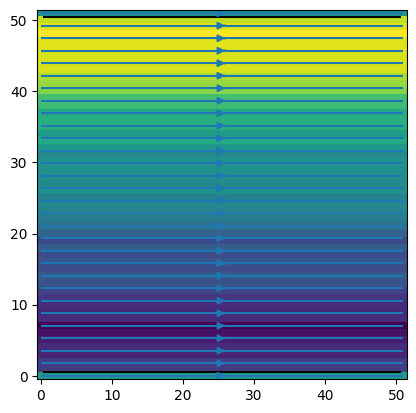

2000


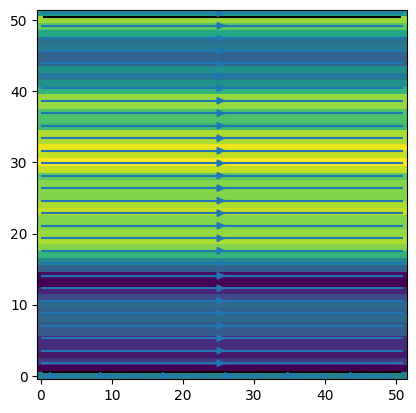

3000


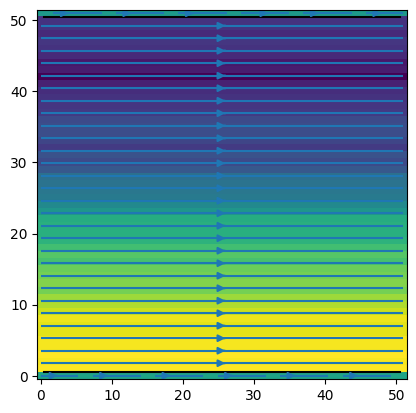

4000


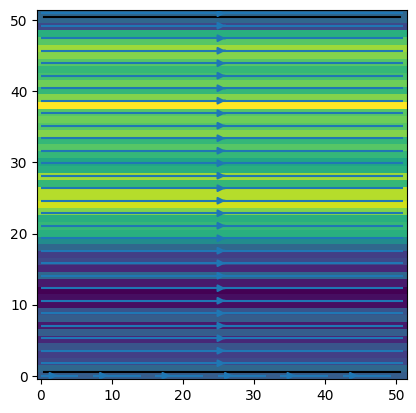

5000


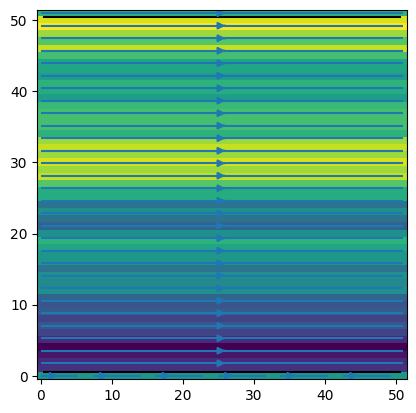

6000


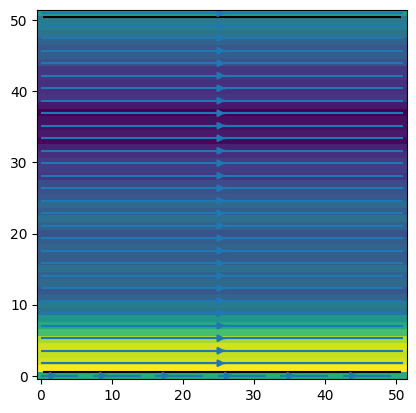

7000


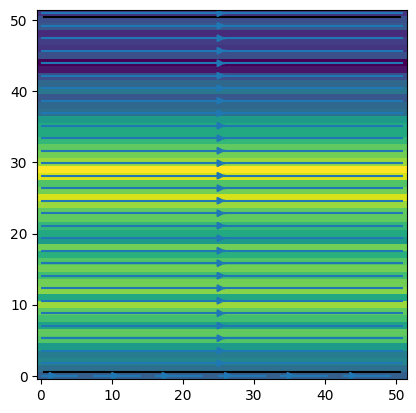

8000


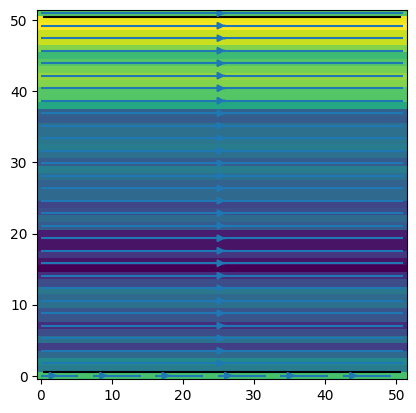

9000


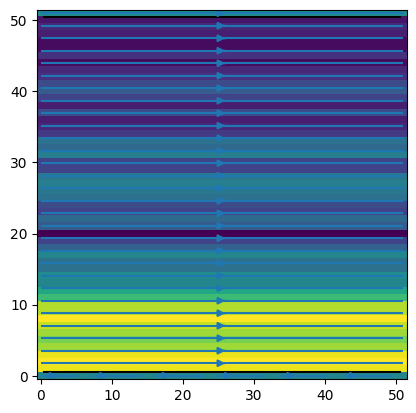

10000


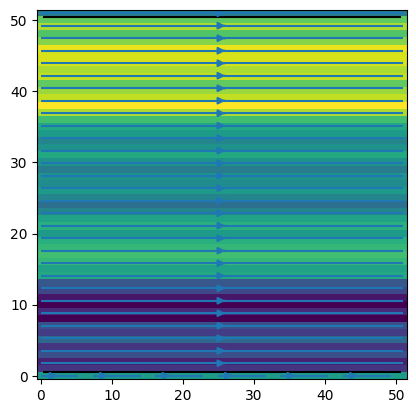

11000


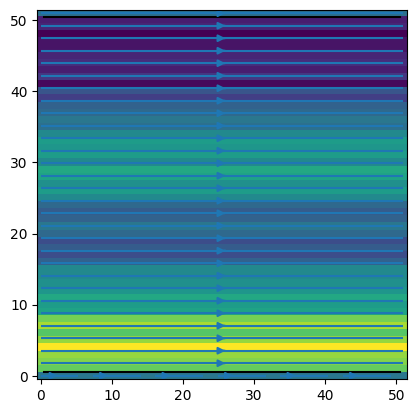

12000


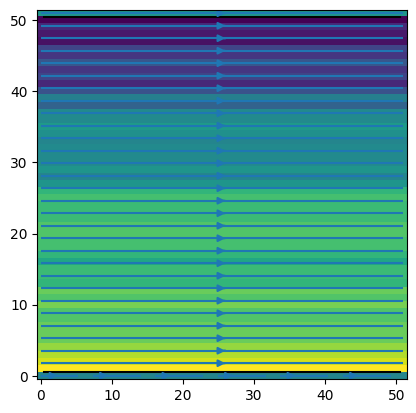

13000


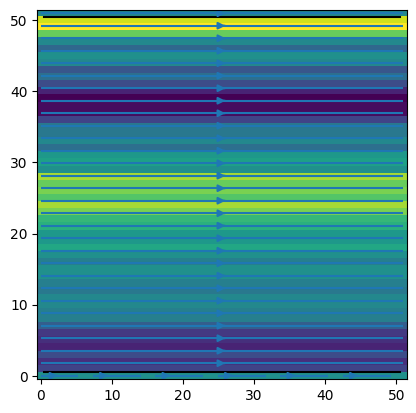

14000


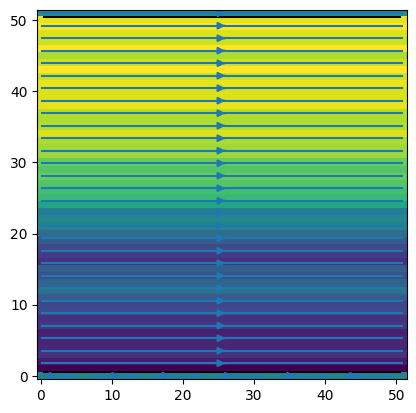

In [323]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
u_periodic = stream_loop(f, 15000, 1000, plot=True)

Config: u = 0.01; omega = 1.5


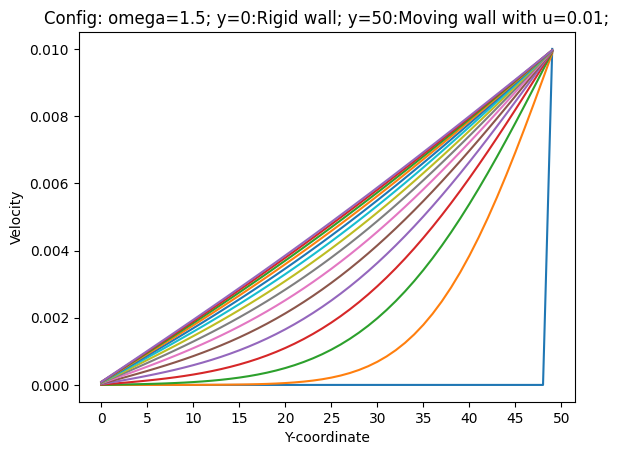

In [328]:
# print(u_periodic.shape)
print(f"Config: u = {ub}; omega = {omega}")
for i in range(u_periodic.shape[0]):
    plt.plot(u_periodic[i][1:-1])
plt.title(f"Config: omega={omega}; y=0:Rigid wall; y=50:Moving wall with u={ub};")
plt.xticks(range(0,nx+1, 5))
plt.xlabel("Y-coordinate")
plt.ylabel("Velocity")
plt.show()